In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Dict



In [20]:
md = pd.read_csv('data\market_data1.csv')

In [21]:
md.head()

,Time,Instrument,Operation,OrderId,Side,Volume,Price,Lifespan
0,0.0,0,Insert,177349435,B,1000.0,1469.0,G
1,0.0,0,Insert,177349439,A,8000.0,1470.0,G
2,0.0,0,Insert,177349467,A,3000.0,1472.0,G
3,0.0,0,Insert,177349475,A,2000.0,1471.0,G
4,0.0,0,Insert,177349487,A,2000.0,1816.0,G


In [22]:
snapshot = md[md['Time']==(md['Time'].unique()[0])]
snapshot

,Time,Instrument,Operation,OrderId,Side,Volume,Price,Lifespan
0,0.0,0,Insert,177349435,B,1000.0,1469.0,G
1,0.0,0,Insert,177349439,A,8000.0,1470.0,G
2,0.0,0,Insert,177349467,A,3000.0,1472.0,G
3,0.0,0,Insert,177349475,A,2000.0,1471.0,G
4,0.0,0,Insert,177349487,A,2000.0,1816.0,G
...,...,...,...,...,...,...,...,...
96,0.0,0,Insert,177353403,B,2000.0,1130.0,G
97,0.0,0,Cancel,177353403,NaN,NaN,NaN,G
98,0.0,0,Insert,177353407,B,2000.0,1129.0,G
99,0.0,0,Cancel,177353407,NaN,NaN,NaN,G


In [23]:
md[md["Operation"]== "Amend"]

,Time,Instrument,Operation,OrderId,Side,Volume,Price,Lifespan
2318,5.483298,0,Amend,177490955,NaN,-1000.0,NaN,G
8756,17.529436,0,Amend,177827279,NaN,-1000.0,NaN,G
12152,23.291846,0,Amend,177970843,NaN,-20000.0,NaN,G
15706,29.474572,0,Amend,178121187,NaN,-20000.0,NaN,G
16451,31.080238,0,Amend,178354139,NaN,-20000.0,NaN,G
...,...,...,...,...,...,...,...,...
450596,872.495706,0,Amend,204462787,NaN,-20000.0,NaN,G
452096,875.060779,0,Amend,204588539,NaN,-20000.0,NaN,G
454195,880.043257,0,Amend,202608203,NaN,-20000.0,NaN,G
459599,894.573871,0,Amend,205063587,NaN,-20000.0,NaN,G


In [24]:
type(md["OrderId"][1])

numpy.int64

In [25]:
def prodArr(frame):
    volArr = frame['Volume'].values
    priceArr = frame['Price'].values
    prodArr = np.asarray([priceArr[i]*volArr[i] for i in range(len(frame))])
    return prodArr

def bookMaker(asksORbids :pd.DataFrame) -> np.ndarray:
    volArr = asksORbids['Volume'].values
    priceArr = asksORbids['Price'].values
    singleBook = np.empty((len(priceArr),2))
    for i in range(len(priceArr)):
        singleBook[i][0] = volArr[i]
        singleBook[i][1] = priceArr[i]

    return singleBook

# def cancelOrders(frame):





#not categorized by instrument
def orderBookGenerator(df):
    timeshots = df['Time'].unique()
    orderBook = np.empty((len(timeshots),2)) # [[orderBookAsks 0, orderBooksBids 0], ..., [orderBooksAsks n, orderBooksBids n]]
    # orderbook Asks/Bids = [[volume 0, price 0], ..., [volume n, price n]]
    initFrame = df[df['Time']== timeshots[0]].dropna()
    orderBook[0][0] = bookMaker(initFrame[initFrame['Side'] == 'A'])
    orderBook[0][1] = bookMaker(initFrame[initFrame['Side'] == 'B'])



    for snapshotIter in tqdm(range(1, len(timeshots))):
        timeFrame = df[df['Time']==timeshots[snapshotIter]].dropna()


        orderBook[snapshotIter][0] = bookMaker(timeFrame[timeFrame['Side'] == 'A'])
        orderBook[snapshotIter][1] = bookMaker(timeFrame[timeFrame['Side'] == 'B'])

def sideVar(df):
    timeshots = df['Time'].unique()
    timeVarBySide = np.empty((len(timeshots), 2)) # [[varAsks 0, varBids 0 ], ..., [varAsks n, varBids n]]
    for snapIter in tqdm(range(len(timeshots))):

        timeFrame = df[df['Time']==timeshots[snapIter]].dropna()

        asksFrame = timeFrame[timeFrame['Side']=="A"]
        bidsFrame = timeFrame[timeFrame['Side']=='B']

        asksLiquid = prodArr(asksFrame)
        # print(asksLiquid)
        bidsLiquid = prodArr(bidsFrame)

        asksVar = np.var(asksLiquid)
        bidsVar = np.var(bidsLiquid)

        timeVarBySide[snapIter][0] = asksVar
        timeVarBySide[snapIter][1] = bidsVar
    return timeVarBySide



In [26]:
books = pd.read_json("data/books.json").values

In [35]:
books[4]

array([{'ask_prices': [148900, 147600, 147300, 147200], 'ask_volumes': [78, 10000, 45, 20], 'bid_prices': [147000, 146400, 145300, 144700, 144100], 'bid_volumes': [84, 10000, 18, 20, 31]}],
      dtype=object)

In [37]:
def getPriceVolArr(book: Dict)-> np.array():
    askVolPriceProd = np.array()
    bidVolPriceProd = np.array()
    for it in range(book["ask_volumes"]):
        askVolPriceProd = np.concatenate(
            (askVolPriceProd,
             [book["ask_prices"][it] for t in book["ask_volumes"][it]]),
            axis=None
        )
    for jit in range(book["bid_volumes"]):
        bidVolPriceProd = np.concatenate(
            (bidVolPriceProd,
            [book["bid_prices"][jit] for t in book["bid_volumes"][it]]),
            axis=None
        )
    return askVolPriceProd, bidVolPriceProd

ask_Var = np.empty(len(books))
bid_Var = np.empty(len(books))
ask_mn = np.empty(len(books))
bid_mn = np.empty(len(books))
for i, book in tqdm(enumerate(books)):
    askVPP, bidVPP = getPriceVolArr(book)
    ask_Var[i] = np.var(askVPP) if len(askVPP) !=0 else 0
    ask_mn[i] = np.mean(askVPP) if len(askVPP) !=0 else 0
    bid_Var[i] = np.var(bidVPP) if len(bidVPP) !=0 else 0
    bid_mn[i] = np.mean(bidVPP) if len(bidVPP) !=0 else 0

0it [00:00, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [28]:
def getPriceVolArr(book):
    book = book[0]
    askVolPriceProd = np.array([])
    bidVolPriceProd = np.array([])
    

    askVolPriceProd = np.concatenate(
            (askVolPriceProd,
             [book["ask_prices"] for t in book["ask_volumes"]]),
            axis=None
        )
            
    bidVolPriceProd = np.concatenate(
            (bidVolPriceProd,
            [book["bid_prices"] for t in book["bid_volumes"]]),
            axis=None
        )
    return askVolPriceProd, bidVolPriceProd


In [29]:
ask_Std = np.empty(len(books))
bid_Std = np.empty(len(books))
ask_mn = np.empty(len(books))
bid_mn = np.empty(len(books))
for i in range(len(books)):
    current_book = books[i]
    askVPP, bidVPP = getPriceVolArr(current_book)
    ask_Std[i] = np.sqrt(np.var(askVPP)) if len(askVPP) !=0 else 0
    ask_mn[i] = np.mean(askVPP) if len(askVPP) !=0 else 0
    bid_Std[i] = np.sqrt(np.var(bidVPP)) if len(bidVPP) !=0 else 0
    bid_mn[i] = np.mean(bidVPP) if len(bidVPP) !=0 else 0
    

The fair price of a call option on Apple with strike 160 and expiration 0.25 years is $3.84


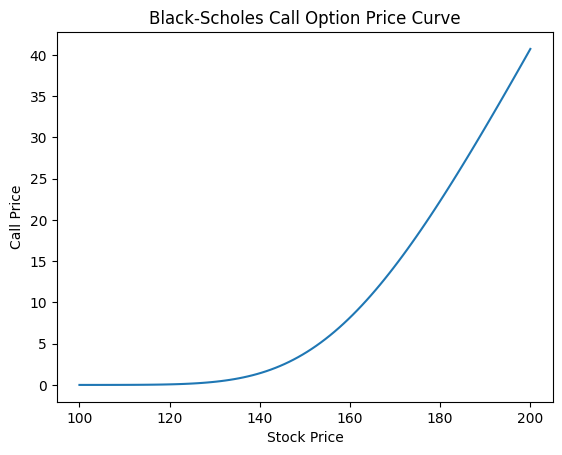

In [40]:
import numpy as np
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt

# Define Black-Scholes formula for call option price
def black_scholes_call(S, K, T, r, sigma):
    # S: current stock price
    # K: strike price
    # T: time to maturity (in years)
    # r: risk-free interest rate (annualized)
    # sigma: volatility of underlying stock (annualized)
    
    # Calculate d1 and d2 parameters
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate call option price using normal cumulative distribution function    
    call = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)

    return call

# Define parameters
S = 150 # Current stock price of Apple ($)
K = 160 # Strike price of call option ($)
T = 0.25 # Time to expiration (in years)
r = 0.01 # Risk-free interest rate (annualized)
sigma = 0.25 # Volatility of underlying stock (annualized)

# Calculate call option price using Black-Scholes formula
call_price = black_scholes_call(S, K, T, r, sigma)

# Print call option price 
print(f"The fair price of a call option on Apple with strike {K} and expiration {T} years is ${call_price:.2f}")

# Plot call option price as a function of current stock price 
S_range = np.linspace(100, 200, 100) # Create a range of possible stock prices 
call_prices = [black_scholes_call(Si, K, T, r, sigma) for Si in S_range] # Calculate corresponding call prices 

plt.plot(S_range, call_prices) # Plot stock prices vs. call prices 
plt.xlabel("Stock Price") # Label x-axis 
plt.ylabel("Call Price") # Label y-axis 
plt.title("Black-Scholes Call Option Price Curve") # Add title 
plt.show()


In [41]:
import tick.hawkes as hk
import numpy as np
import pandas as pd

# Load order book data into a pandas DataFrame
order_book = books

# Preprocess the data to extract relevant information
timestamps = order_book['time'].values
prices = order_book['price'].values
volumes = order_book['volume'].values

# Define the Hawkes process model
model = hk.HawkesExpKern(decay=0.1)

# Fit the model to the data using maximum likelihood estimation
model.fit(timestamps, end_time=timestamps[-1], kernel_params=np.array([0.1]))

# Simulate the Hawkes process for the next 1000 time units
simulated_timestamps = model.simulate(1000)

# Evaluate the goodness-of-fit of the simulated Hawkes process
# to the original data using statistical tests and measures
# (e.g., the Kolmogorov-Smirnov test or the Cramer-von Mises test)


ModuleNotFoundError: No module named 'tick'

In [ ]:
def price_shit():
    bid =
    ask =

    